In [71]:
import numpy as np
import h5py as h5

import healpy as hp
from fpipe.map import algebra as al

import matplotlib.pyplot as plt

import gc

from fpipe.point_source import source

from fpipe.timestream import data_format

from astropy.time import Time

from scipy.optimize import leastsq

In [110]:
def rms_ABBA_map(m, mask):

    freq_l = m.shape[0]/4 * 4
    m      = m[:freq_l, :]
    mask   = mask[:freq_l, :]
    shp = m.shape
    m.shape = (-1, 4, shp[-1])
    m = 0.5 * ( m[:, 1, :] + m[:, 2, :] ) - 0.5 * ( m[:, 0, :] + m[:, 3, :] )
    
    mask.shape = (-1, 4, shp[-1] )
    mask = mask[:, 0, :] + mask[:, 1, :] + mask[:, 2, :] + mask[:, 3, :]
    
    #print m.shape
    m[mask] = 0
    return m, mask


def est_rms(imap, mask, pixs_sel=None, axis=None, K2mJy=1.):
    
    if pixs_sel is not None:
        imap = imap[:, pixs_sel]
        mask = mask[:, pixs_sel]

    imap = imap.copy() * K2mJy[:, None]

    #imap_diff = imap[1:, :] - imap[:-1, :]
    #imap_diff_mask = mask[1:, :] + mask[:-1, :]
    imap_diff, imap_diff_mask = rms_ABBA_map(imap, mask)

    imap_cont = (~imap_diff_mask).astype('float')
    
    imap_mean = np.sum(imap_diff, axis=axis)
    norm = np.sum(imap_cont, axis=axis)
    norm[norm==0] = np.inf
    imap_mean = imap_mean / norm
    
    if axis is not None:
        imap_mean = imap_mean[:, None]
    imap_var = np.sum( (imap_diff - imap_mean)**2, axis=axis ) / norm
    
    imap_rms = np.sqrt( imap_var)
    imap_rms_mean = imap_rms / np.sqrt(norm)

    del imap_diff, imap_diff_mask, imap
    gc.collect()
    
    return imap_var, imap_rms, imap_mean, imap_rms_mean

In [3]:
def iter_tod(file_root, file_name_list, freq_band = '1250-1450MHz'):
    
    for file_name in file_name_list:
        file_list = [file_root + '%s_arcdrift%04d-%04d_%s.h5'%(file_name, i, i, freq_band)
                     for i in range(1, 8)]    
        for name in file_list:
            with h5.File(name, 'r') as f:
                #_ra.append(f['ra'][:])
                #_dec.append(f['dec'][:])
                #_on.append(f['ns_on'][:])
                ra  = f['ra'][:]
                dec = f['dec'][:]
                ns_on = f['ns_on'][:]
                freq = f['freq'][:]
                mask  = f['vis_mask'][:].astype('bool')
                time = Time(f['sec1970'][:], format='unix')
            yield name, time, ra, dec, ns_on, mask, freq

def output_radec(file_root, file_name_list):

    radec_list = []
    for file_name in file_name_list:
        file_list = [file_root + '%s_arcdrift%04d-%04d_1250-1450MHz.h5'%(file_name, i, i)
                     for i in range(1, 8)]
        output_name = file_name.replace('/', '_')
        
        #fdata = data_format.FASTh5_Spec(file_list, fmin=3000, fmax=3010)
        _ra = []
        _dec = []
        _on = []
        for name in file_list:
            with h5.File(name, 'r') as f:
                _ra.append(f['ra'][:])
                _dec.append(f['dec'][:])
                _on.append(f['ns_on'][:])
                time = Time(f['sec1970'][:], format='unix')
                print name
                print time[0].fits
                print time[-1].fits
                print (time[-1] - time[0]) * 60. * 24
                print '%d x %f = %f'%(time.shape[0], (time[1] - time[0]).value * 60. * 24 * 60.,
                                     time.shape[0] * (time[1] - time[0]).value * 60. * 24 * 60.)
                print
        
        _ra = np.concatenate(_ra, axis=0)
        _dec = np.concatenate(_dec, axis=0)
        _on = np.concatenate(_on, axis=0)

        radec_list.append([_ra[~_on[:, 0], :], _dec[~_on[:, 0], :]])
        
    return radec_list

In [4]:
map_name = '/scratch3/users/ycli/fanalysis/map_df28k_sumfeeds_CC_centeronly/Combined_1250-1450MHz.h5'
with h5.File(map_name, 'r') as f:
    print f.keys()
    imap = al.load_h5(f, 'clean_map')
    imap_h = al.make_vect(imap, axis_names = imap.info['axes'])
    nside = f['nside'][()]
    pixs = f['map_pix'][:]
    freq_h = imap_h.get_axis('freq')
    
map_name = '/scratch3/users/ycli/fanalysis/map_df28k_sumfeeds_CC_centeronly/Combined_1050-1150MHz.h5'
with h5.File(map_name, 'r') as f:
    print f.keys()
    imap = al.load_h5(f, 'clean_map')
    imap_l = al.make_vect(imap, axis_names = imap.info['axes'])
    nside = f['nside'][()]
    pixs = f['map_pix'][:]
    freq_l = imap_l.get_axis('freq')

imap = np.concatenate([imap_l, imap_h], axis=0)
freq = np.concatenate([freq_l, freq_h])

#mask = imap == 0

[u'clean_map', u'map_pix', u'noise_diag', u'nside']


/users/ycli/code/fpipe/fpipe/map/algebra.py:1044: UserWarning: Initialization argument ignored. Requisite metadata for vector already exists. Clear info dictionary if you want opposite behaviour.
  warnings.warn("Initialization argument ignored. Requisite "


[u'clean_map', u'map_pix', u'noise_diag', u'nside']


In [9]:
file_root = '/scratch3/users/ycli/fanalysis/rb4_rmbsl_sumfeeds_CC/'
file_name_list = ['20210314/HIMGS_1100+2610',
                  '20210302/HIMGS_1100+2600', '20210305/HIMGS_1100+2632', 
                  '20210306/HIMGS_1100+2643', '20210307/HIMGS_1100+2654', 
                  '20210309/HIMGS_1100+2610', '20210313/HIMGS_1100+2621', 
                  ]

hit_freq_list_h = []
for tod in iter_tod(file_root, file_name_list, freq_band='1250-1450MHz'):
    name, time, ra, dec, ns_on, mask, freq_h = tod
    hit_freq_list_h.append( ( np.sum((~mask).astype('uint'), axis=(0, 2, 3)) / 2. )[None, :] )
hit_freq_list_h = np.concatenate(hit_freq_list_h, axis=0)


hit_freq_list_l = []
for tod in iter_tod(file_root, file_name_list, freq_band='1050-1150MHz'):
    name, time, ra, dec, ns_on, mask, freq_l = tod
    hit_freq_list_l.append( ( np.sum((~mask).astype('uint'), axis=(0, 2, 3)) / 2. )[None, :] )
hit_freq_list_l = np.concatenate(hit_freq_list_l, axis=0)

In [111]:
K2mJy = 1. /source.mJy2K(freq_h * 1.e-3) * 0 + 1.
var, rms_h, mean, rms_mean = est_rms(imap_h, imap_h == 0, axis=(1, ), K2mJy=K2mJy)
K2mJy = 1. /source.mJy2K(freq_l * 1.e-3) * 0 + 1.
var, rms_l, mean, rms_mean = est_rms(imap_l, imap_l == 0, axis=(1, ), K2mJy=K2mJy)

36.1041953641433 32.818519468338636


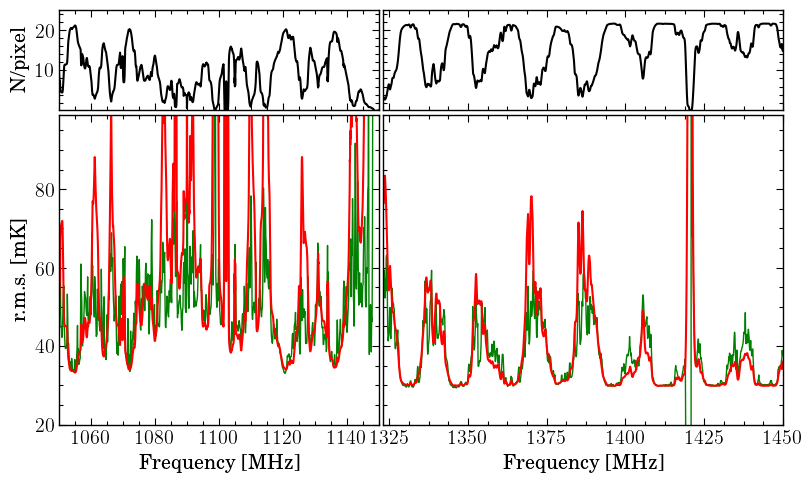

In [115]:
fig = plt.figure(figsize=(8, 5))
ax1  = fig.add_axes([0.07, 0.15, 0.4, 0.62])
ax2  = fig.add_axes([0.475, 0.15, 0.5, 0.62])

ax3  = fig.add_axes([0.07, 0.78, 0.4, 0.2])
ax4  = fig.add_axes([0.475, 0.78, 0.5, 0.2])



#rms_mask = rms > 3.
#rms = np.ma.array(rms, mask=rms_mask)

rms_l = np.ma.masked_equal(rms_l, 0)
freq_len_l = freq_l.shape[0] / 4 * 4
freq_l_rebin = np.mean(freq_l[:freq_len_l].reshape((-1, 4)), axis=1)
ax1.plot(freq_l_rebin, rms_l * 1.e3, 'g-', lw=1.0)
freq_len_h = freq_h.shape[0] / 4 * 4
freq_h_rebin = np.mean(freq_h[:freq_len_h].reshape((-1, 4)), axis=1)
ax2.plot(freq_h_rebin, rms_h * 1.e3, 'g-', lw=1.0)

norm = 86897.
hit_freq_l = np.sum(hit_freq_list_l, axis=0) / norm
hit_freq_h = np.sum(hit_freq_list_h, axis=0) / norm

hit_freq_l_rebin = hit_freq_l[:freq_len_l]
hit_freq_l_rebin = np.mean(hit_freq_l_rebin.reshape((-1, 4)), axis=1)
sel = hit_freq_l_rebin > 5
func_l = lambda A: np.log10( A / ( hit_freq_l_rebin[sel] * 2. * 28e3 )**0.5 ) - np.log10( rms_l[sel] )
r_l = leastsq(func_l, 30.)[0][0]

#sel = hit_freq_h[1:] > 5
#func_h = lambda A: np.log10( A / ( hit_freq_h[1:][sel] * 2. * 28e3 )**0.5 ) - np.log10( rms_h[sel] )
#r_h = leastsq(func_h, 30.)[0][0]
hit_freq_h_rebin = hit_freq_h[:freq_len_h]
hit_freq_h_rebin = np.mean(hit_freq_h_rebin.reshape((-1, 4)), axis=1)
sel = hit_freq_h_rebin > 5
func_h = lambda A: np.log10( A / ( hit_freq_h_rebin[sel] * 2. * 28e3 )**0.5 ) - np.log10( rms_h[sel] )
r_h = leastsq(func_h, 30.)[0][0]

print r_l, r_h

ax1.plot(freq_l, r_l * 1.e3/( hit_freq_l * 2. * 28e3 )**0.5, 'r-')
ax2.plot(freq_h, r_h * 1.e3/( hit_freq_h * 2. * 28e3 )**0.5, 'r-')

ax3.plot(freq_l, hit_freq_l, 'k-')
ax4.plot(freq_h, hit_freq_h, 'k-')

ax1.set_ylim(20, 99)
ax1.set_xlim(1050, 1150)
ax1.set_ylabel('r.m.s. [mK]')
ax1.set_xlabel('Frequency [MHz]')

ax2.set_ylim(20, 99)
ax2.set_xlim(1323, 1450)
#ax2.set_ylabel('r.m.s. [K]')
ax2.set_yticklabels([])
ax2.set_xlabel('Frequency [MHz]')


ax3.set_xticklabels([])
ax3.set_ylabel('N/pixel')
ax3.set_xlim(1050, 1150)
ax3.set_ylim(0.3, 25)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.set_xlim(1323, 1450)
ax4.set_ylim(0.3, 25)

fig.savefig('output/map_rms.png', dpi=400)


In [104]:
print np.median(hit_freq_h), np.mean(hit_freq_h)
print np.median(hit_freq_l), np.mean(hit_freq_l)

17.363844551595566 15.505315759453625
8.860668377504402 9.140265703113096


In [116]:
def plot_map_rms(imap, mask, freq, radec_list, nside, pixs, dec_bins_edges = np.linspace(25.70, 27.2, 51), 
                 axes=None, label='', Tsys=None):
    
    # ----------------------------------------------------------------------------
    dec_hist = np.zeros(dec_bins_edges.shape[0] - 1)
    hit_map = np.zeros(pixs.shape[0])
    hit_map_bins = np.append(pixs, pixs[-1] + 1) - 0.5
    for i in range(len(radec_list)):
        for j in range(19):
            _ra  = radec_list[i][0][:, j]
            _dec = radec_list[i][1][:, j]
            #dec_hist += np.histogram(_dec, bins=dec_bins_edges)[0] * 1.
            hit_map += np.histogram(hp.ang2pix(nside, _ra, _dec, lonlat=True), bins=hit_map_bins)[0] * 1.
    
    
    # ----------------------------------------------------------------------------
    K2mJy = np.ones(freq.shape) * 1.e3
    freq_rms = est_rms(imap, mask, axis=(1, ), K2mJy=K2mJy)[1]
    freq_mask = freq_rms > 50.
    mask[1:, :][freq_mask] = True
    
    ra, dec = hp.pix2ang(nside, pixs, lonlat=True)
    rms_list = []
    hit_list = []
    for i in range(dec_bins_edges.shape[0] - 1):
        
        K2mJy = np.ones(freq.shape) * 1.e3 #1./source.mJy2K(freq * 1.e-3)
        pixs_sel = ( dec > dec_bins_edges[i] ) * ( dec <= dec_bins_edges[i+1] )
        var, rms, mean, rms_mean = est_rms(imap, mask, pixs_sel=pixs_sel, K2mJy=K2mJy)
        
        hit_list.append(np.mean(hit_map[pixs_sel]))
        
        rms_list.append(rms)
        
    dec_bins = 0.5 * ( dec_bins_edges[1:] + dec_bins_edges[:-1] )
    rms = np.array(rms_list)
    rms = np.ma.masked_equal(rms, 0)
    
    hit = np.array(hit_list)
    hit = np.ma.masked_equal(hit, 0)
    
    # ----------------------------------------------------------------------------
    if axes is None:
        fig = plt.figure(figsize=(8, 4))
        ax  = fig.add_axes([0.07, 0.15, 0.9, 0.82])
    else:
        fig, ax = axes
    
    l = ax.plot(dec_bins, rms, 'o-', lw=1., label=label)

    if Tsys is not None:
        rms_th = Tsys * 1.e3 / np.sqrt(hit * 2. * 7.6e3 * 4)
        ax.plot(dec_bins, rms_th, '--', color=l[0].get_color(), lw=2., drawstyle='steps-mid')
    
    ax.set_ylim(0., 99)
    
    ax.set_xlim(dec_bins.min(), dec_bins.max())
    ax.set_ylabel('r.m.s. [mK]')
    ax.set_xlabel('Dec. [deg]')
    #ax.set_xlabel('Frequency [MHz]')
    #fig.savefig('output/map_rms_dec.png', dpi=400)
    
    return fig, ax

In [41]:
file_root = '/scratch3/users/ycli/fanalysis/rb4_rmbsl_sumfeeds_CC/'
file_name_list = ['20210314/HIMGS_1100+2610',
                  '20210302/HIMGS_1100+2600', '20210305/HIMGS_1100+2632', 
                  '20210306/HIMGS_1100+2643', '20210307/HIMGS_1100+2654', 
                  '20210309/HIMGS_1100+2610', '20210313/HIMGS_1100+2621', 
                  ]

radec_list = output_radec(file_root, file_name_list)

/scratch3/users/ycli/fanalysis/rb4_rmbsl_sumfeeds_CC/20210314/HIMGS_1100+2610_arcdrift0001-0001_1250-1450MHz.h5
2021-03-14T14:23:42.000(UTC)
2021-03-14T14:57:58.551(UTC)
34.2758522828
2044 x 1.006633 = 2057.557940

/scratch3/users/ycli/fanalysis/rb4_rmbsl_sumfeeds_CC/20210314/HIMGS_1100+2610_arcdrift0002-0002_1250-1450MHz.h5
2021-03-14T14:57:59.558(UTC)
2021-03-14T15:32:16.109(UTC)
34.2758522868
2044 x 1.006633 = 2057.557940

/scratch3/users/ycli/fanalysis/rb4_rmbsl_sumfeeds_CC/20210314/HIMGS_1100+2610_arcdrift0003-0003_1250-1450MHz.h5
2021-03-14T15:32:17.116(UTC)
2021-03-14T16:06:33.667(UTC)
34.2758522948
2044 x 1.006633 = 2057.557940

/scratch3/users/ycli/fanalysis/rb4_rmbsl_sumfeeds_CC/20210314/HIMGS_1100+2610_arcdrift0004-0004_1250-1450MHz.h5
2021-03-14T16:06:34.673(UTC)
2021-03-14T16:40:51.224(UTC)
34.2758522948
2044 x 1.006633 = 2057.557940

/scratch3/users/ycli/fanalysis/rb4_rmbsl_sumfeeds_CC/20210314/HIMGS_1100+2610_arcdrift0005-0005_1250-1450MHz.h5
2021-03-14T16:40:52.231(UTC)

In [117]:
dec_bins_edges = np.linspace(25.70, 27.2, 51)
axes = None
axes = plot_map_rms(imap_h, imap_h==0, freq_h, radec_list, nside, pixs, 
                    dec_bins_edges = dec_bins_edges, axes=axes, Tsys=36.36174793018, 
                    label='1050-1135 MHz')
axes = plot_map_rms(imap_l, imap_l==0, freq_l, radec_list, nside, pixs, 
                    dec_bins_edges = dec_bins_edges, axes=axes, Tsys=32.79513744481784,
                    label='1310-1450 MHz')
fig, ax = axes
ax.legend()
plt.show()
fig.savefig('output/map_rms_dec.png', dpi=200)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 4152 but corresponding boolean dimension is 1038

/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:52: RuntimeWarning: divide by zero encountered in divide


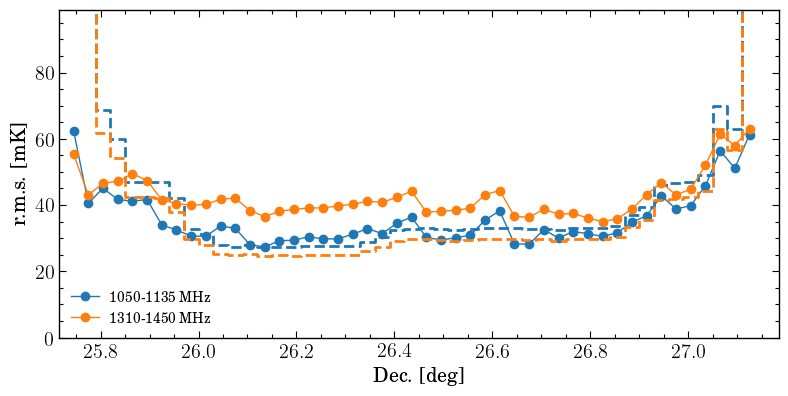

In [93]:
def plot_diffmap(imap, mask, bins, pixs_sel=None, axes=None):
    
    imap = imap.copy()
    if pixs_sel is not None:
        imap = imap[:, pixs_sel]
        mask = mask[:, pixs_sel]
        
    imap_diff = imap[1:, :] - imap[:-1, :]
    imap_diff_mask = mask[1:, :] + mask[:-1, :]
    imap_diff[imap_diff_mask] = 0

    dbin = bins[-1] / bins[-2]
    bin_edgs = np.append(bins, bins[-1] * dbin) / (dbin**0.5)
    hist = np.histogram(np.abs(imap_diff.flatten()), bins=bin_edgs)[0] * 1.

    if axes is None:
        fig = plt.figure(figsize=(7, 6))
        ax  = fig.add_axes([0.07, 0.15, 0.9, 0.82])
    else:
        fig, ax = axes
    
    dbin = bin_edgs[1:] - bin_edgs[:-1]
    ax.plot(bins, hist/dbin, '.-', drawstyle='steps-mid')
    ax.loglog()
    #ax.set_ylim(1, 1.e8)

    return fig, ax


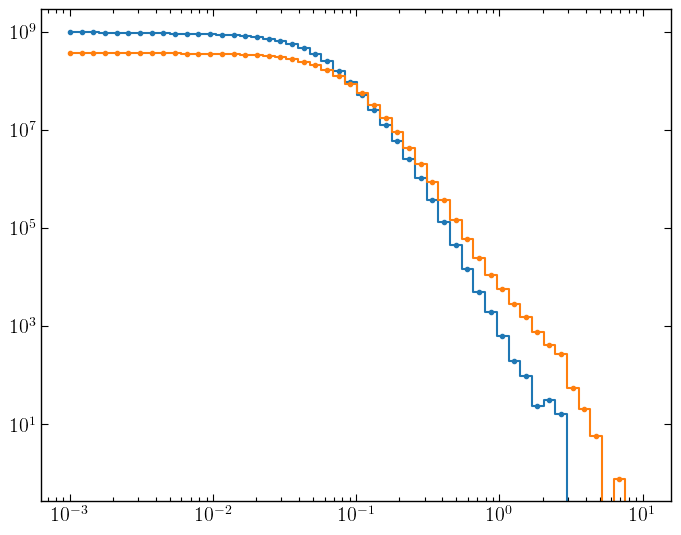

In [94]:
axes = None
bins = np.logspace(-3, 1)
axes = plot_diffmap(imap_h, imap_h==0, bins=bins, pixs_sel=None, axes=axes)
axes = plot_diffmap(imap_l, imap_l==0, bins=bins, pixs_sel=None, axes=axes)